# 목표

- CNN에서 합성곱이 어떤식으로 처리되는지 이해
  - 데이터의 변화 확인 (이미지)
- CNN에서 풀링이 어떤식으로 처리되는지 이해
  - 데이터의 변화 확인 (이미지)
- 편향, 패딩은 고정하고 사용
- x, W, s, p 간의 공식 확인
- W를 직접 설계 (수직, 수평, 빛의 방향 검토)

In [36]:
import torch
torch.__version__

'1.11.0+cu113'

# 이미지 준비

In [37]:
import matplotlib.pyplot as plt
# Pillow
from PIL import Image

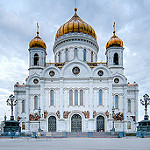

In [38]:
img = Image.open( '/content/drive/MyDrive/디지털트레이닝/딥러닝/dl/torch3.png' )
img

In [39]:
import numpy as np

In [40]:
tmp = np.array( img )
tmp.shape, img.size

((150, 150, 3), (150, 150))

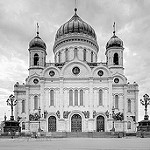

In [41]:
# 칼라이미지를 grayscale로 처리해서 1채널 이미지로 컨버팅
# "L" = R*(299/1000) + G*(나머지값/1000) + B*(114/1000)

img = img.convert("L")
img

In [42]:
# 1채널 이미지라서 채널값 자체가 사라졌다

tmp = np.array( img )
tmp.shape, img.size

((150, 150), (150, 150))

In [43]:
img_Tensor = torch.Tensor( tmp )
img_Tensor.size()

torch.Size([150, 150])

In [44]:
# 그레이스케일 이미지 이므로, 0 ~ 255

img_Tensor, img_Tensor.min(),  img_Tensor.max()

(tensor([[212., 213., 215.,  ..., 197., 199., 200.],
         [215., 216., 216.,  ..., 197., 199., 200.],
         [214., 215., 216.,  ..., 196., 197., 198.],
         ...,
         [171., 171., 172.,  ..., 163., 166., 161.],
         [174., 174., 174.,  ..., 173., 175., 168.],
         [168., 168., 168.,  ..., 158., 159., 150.]]),
 tensor(0.),
 tensor(255.))

In [45]:
# 커널 : 가중치 W를 공용파라미터로 가진 커널(필터)
#        이미지 상의 공간정보, 인접정보등 특징 추출 용도
#        이런 특징이 어떤것들인가? => 수직, 수평 성분 추출
# 특정 크기를 가진 커널에 수직, 수평정보를 추출하는 W를 가진
# 값을 넣어서 합성곱 과정을 수행

kernel = torch.Tensor( [
    [ 1, 0, -1 ],
    [ 1, 0, -1 ],
    [ 1, 0, -1 ]                    
] )

kernel, kernel.size()

(tensor([[ 1.,  0., -1.],
         [ 1.,  0., -1.],
         [ 1.,  0., -1.]]), torch.Size([3, 3]))

In [46]:
# 수평 커널

kernel.T

tensor([[ 1.,  1.,  1.],
        [ 0.,  0.,  0.],
        [-1., -1., -1.]])

In [47]:
# 이미지 높이, 너비

height, width = img_Tensor.size()
height, width

(150, 150)

In [48]:
# stride 값

stride = 1

In [49]:
# 이미지 상의 좌표 -> 4/4 분면 사용
# 왼쪽 상단 귀퉁이가 ( 0, 0 )


In [50]:
k_h, k_w = kernel.size()

## 실제 구현

In [51]:
for i in range( 0, height - k_h + 1, stride ):   # 높이
  
  # 가로 한 줄에 대한 특징 추출이 끝나면 담는 그릇
  
  tmp = list()
  for j in range( 0, width - k_w + 1, stride ): # 너비

  # 목표: 이미지 공간상에 있는 정보를 추출
  # 1. 커널과 겹쳐있는 이미지 데이터를 추출
  
    img_target = img_Tensor[ i : ( i + k_h ), j : ( j + k_w )]

  # 2. 연산 (행렬간 곱을 수행 후 원소 합산 -> 내적 )

    print( img_target )
    print( img_target * kernel )
    print( torch.sum( img_target * kernel ) )
    tmp.append( torch.sum( img_target * kernel ) )

    # 내적 수행 시 오류가 발생 -> 원인 나중에 체크
    # print( torch.dot( img_target, kernel ) )

    break
    pass

  break
  pass

tensor([[212., 213., 215.],
        [215., 216., 216.],
        [214., 215., 216.]])
tensor([[ 212.,    0., -215.],
        [ 215.,    0., -216.],
        [ 214.,    0., -216.]])
tensor(-6.)


In [52]:
finalMap = list()

for i in range( 0, height - k_h + 1, stride ):   # 높이
  
  tmp = list()

  for j in range( 0, width - k_w + 1, stride ): # 너비
  
    img_target = img_Tensor[ i : ( i + k_h ), j : ( j + k_w )]
    tmp.append( torch.sum( img_target * kernel ) )

  finalMap.append( tmp )

conv1_img = torch.Tensor( finalMap )
conv1_img.size()

torch.Size([148, 148])

In [53]:
# 합성곱층의 커스텀 함수화

def myConvolution_Func( x, kernel, stride = ( 1, 1 ) ):
  
  '''
    - 직접 구현한 (일부 조건은 고정) 합성곱 함수
    x: 원본 이미지
    kernel: 가중치 W를 공용 파라미터로 가진 커널
  '''

  # shape 계산

  x_h, x_w = x.size()
  k_h, k_w = kernel.size()
  s_h, s_w = stride

  finalMap = list()

  finalMap = list()
  for i in range(0, x_h-k_h+1, s_h):   # 높이 
    tmp = list()
    for j in range(0, x_w-k_w+1, s_w):  # 너비      
      tmp.append(torch.sum(img_Tensor[i:(i+k_h),j:(j+k_w)]*kernel))
    finalMap.append( tmp )
  
  return torch.Tensor( finalMap )

  pass

In [54]:
img_Tensor

tensor([[212., 213., 215.,  ..., 197., 199., 200.],
        [215., 216., 216.,  ..., 197., 199., 200.],
        [214., 215., 216.,  ..., 196., 197., 198.],
        ...,
        [171., 171., 172.,  ..., 163., 166., 161.],
        [174., 174., 174.,  ..., 173., 175., 168.],
        [168., 168., 168.,  ..., 158., 159., 150.]])

In [55]:
# 수직 정보를 추출하는 가중치를 가진 커널을 통과시킨 특징맵

vertical_conv_img = myConvolution_Func( img_Tensor, kernel )
vertical_conv_img

tensor([[ -6.,  -3.,   3.,  ...,  -8., -10.,  -8.],
        [ -6.,  -4.,  -1.,  ...,  -7.,  -7.,  -4.],
        [ -9., -10.,  -8.,  ...,  -3.,  -1.,   1.],
        ...,
        [  0.,   1.,   2.,  ...,   2.,  -1.,   5.],
        [ -1.,  -1.,   0.,  ...,   4.,   2.,   8.],
        [ -1.,  -2.,   0.,  ...,   4.,   6.,  15.]])

In [56]:
# 수평커널 적용

horizontal_conv_img = myConvolution_Func( img_Tensor, kernel.T )
horizontal_conv_img

tensor([[ -5.,  -4.,  -3.,  ...,   5.,   5.,   5.],
        [ 16.,  13.,   7.,  ...,   3.,   8.,  13.],
        [ 28.,  23.,  14.,  ...,   2.,   8.,  15.],
        ...,
        [-27., -30., -32.,  ...,  19.,  21.,  22.],
        [-42., -44., -46.,  ...,  -2.,   1.,   6.],
        [ 10.,  11.,  13.,  ...,  15.,  17.,  23.]])

# 합성곱을 통과한 특징맵 결과 확인

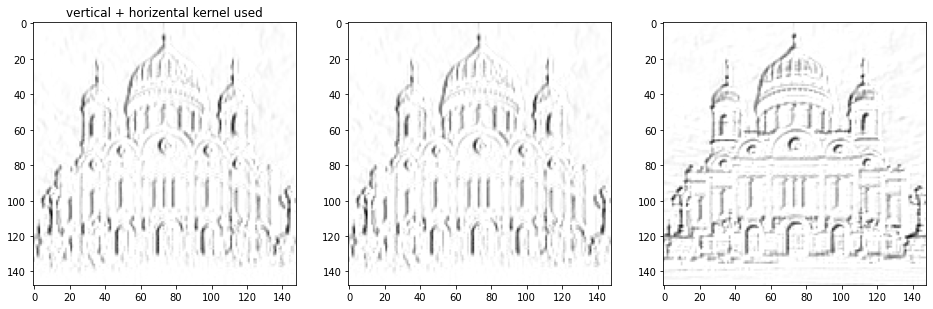

In [62]:
fig, (ax1, ax2, ax3) = plt.subplots( 1, 3, figsize = ( 16, 9 ) )

# 수직 커널 적용

ax1.imshow( torch.relu( vertical_conv_img ), cmap='binary' )
ax1.set_title('vertical kernel used')

# 수평 커널 적용

ax2.imshow( torch.relu( vertical_conv_img ), cmap='binary' )
ax1.set_title('horizental kernel used')

# 수직 + 수평 동시 적용

ax3.imshow( torch.relu( vertical_conv_img + horizontal_conv_img ), cmap='binary' )
ax1.set_title('vertical + horizental kernel used')

plt.show()

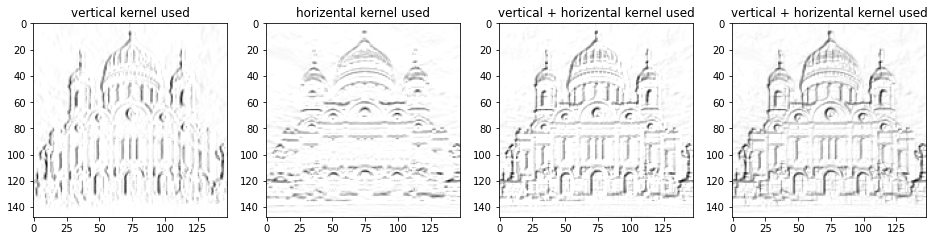

In [64]:
# 활성화 함수를 사용하여 음수값(이미지 픽셀중) 처리

fig, (ax1, ax2, ax3, ax4) = plt.subplots( 1, 4, figsize=(16,9))

# 수직 커널 적용 

ax1.imshow( torch.relu( vertical_conv_img ), cmap='binary' )
ax1.set_title('vertical kernel used')

# 수평 커널 적용

ax2.imshow( torch.relu( horizontal_conv_img), cmap='binary' )
ax2.set_title('horizental kernel used')

# 수직+수평동시 적용

ax3.imshow( torch.relu( vertical_conv_img + horizontal_conv_img), cmap='binary' )
ax3.set_title('vertical + horizental kernel used')

# 각각 활성화를 처리하여 합산하는 경우 -> 정보(특징이 명확했다)가 정확했다

ax4.imshow( torch.relu( vertical_conv_img) + torch.relu( horizontal_conv_img), cmap='binary' )
ax4.set_title('vertical + horizental kernel used')

plt.show()

In [65]:
import torch.nn as nn

In [69]:
# 엔진별로 이미지 포맷을 사용 (파이토치) -> NCHW
# ( 1, 1, 150, 150 )

h, w = img_Tensor.size()

In [71]:
# 차원 변경

curimg = img_Tensor.view( 1, 1, h, w )
curimg.size()

torch.Size([1, 1, 150, 150])

In [73]:
# 차원을 확장 ( 2D -> 4D )

curimg = img_Tensor.expand( 1, 1, h, w )
curimg.size()

torch.Size([1, 1, 150, 150])

In [75]:
batch, in_channel, h, w = curimg.size()

# 설정값

out_channel = 1
kernel_size = 3
stride      = 1

In [78]:
# api를 이용한 합성곱 생성

conv_layer = nn.Conv2d(
    in_channels  = in_channel,
    out_channels = out_channel,
    kernel_size  = kernel_size,
    stride       = stride,
    bias         = False
 )

In [79]:
conv_layer

Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)

In [81]:
# 기본값으로 가중치값이 설정

conv_layer.weight.data, conv_layer.weight.data.size()

(tensor([[[[-0.0311,  0.0191,  0.2193],
           [ 0.0028, -0.1351,  0.0952],
           [-0.2022, -0.1960, -0.0675]]]]), torch.Size([1, 1, 3, 3]))

In [82]:
# 가중치에 수직 커널값 입력

conv_layer.weight.data = kernel.expand( 1, 1, kernel.size( 0 ), kernel.size( 1 ) )
conv_layer.weight.data

tensor([[[[ 1.,  0., -1.],
          [ 1.,  0., -1.],
          [ 1.,  0., -1.]]]])

In [86]:
convs = conv_layer( curimg )
convs.size()

# [ 1, 1, 148, 148 ] -> [ 148, 148 ]

torch.Size([1, 1, 148, 148])

In [87]:
convs.squeeze().size()

torch.Size([148, 148])

In [89]:
convs.squeeze() == vertical_conv_img

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

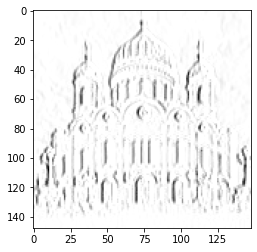

In [91]:
# 합성곱 api를 활용하면 내부적으로 미분이 걸려있어서 락이 되어있다
# 해제 후 처리 -> detach()

plt.imshow( torch.relu( convs.squeeze() ).detach().numpy(), cmap = 'binary' )
plt.show()

# 관계식

- k(W), s, p, h, w
  - 커널, 스트라이드, 패딩, 이미지높이 / 너비
  - 합성곱 통과 후 이미지 높이
    - H = ( ( h + 2 * p - k ) / s ) + 1
      - ( ( 150 + 2 * 0 - 3 ) / 1 ) + 1
      - ( ( 150 - 3 ) / 1 ) + 1
      - ( 147 / 1 ) + 1
      - 148
    - W = ( ( w + 2 * p - k ) / s ) + 1

- 이를 이용해서 합성곱층을 통과하는 이미지의 변화를 미리 예측해서 설계할 수 있다

# 최대 풀링 구현

In [93]:
activation_map = torch.relu( vertical_conv_img )
activation_map

tensor([[ 0.,  0.,  3.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  1.],
        ...,
        [ 0.,  1.,  2.,  ...,  2.,  0.,  5.],
        [ 0.,  0.,  0.,  ...,  4.,  2.,  8.],
        [ 0.,  0.,  0.,  ...,  4.,  6., 15.]])

In [94]:
# 커널 사이즈

kernel_size = 2

# 이동량

stride_size = 2
# (148, 148) -> (74, 74) 예측, 특성이 강회된다 본질 체크

- 풀링 처리를 위해서 텐서쪽 지원함수 활용, unfold() 를 활용

In [95]:
# NCHW 예시

tmp = torch.arange( 0, 16 ).view( 1, 1, 4, 4 )
tmp

# 여기서 최대값을 구한다면 0, 1, 4, 5를 하나의 그룹으로 묶어서 그 중의 최대값

tensor([[[[ 0,  1,  2,  3],
          [ 4,  5,  6,  7],
          [ 8,  9, 10, 11],
          [12, 13, 14, 15]]]])

In [102]:
# unfold를 이용하여 maxpool or avg pool을 처리할 대상을 추출
# kernel -> 2번 인자 고려, stride는 3번 인자 고려 
# dimension -> 2

tmp.unfold( 2, 2, 2 ), tmp.unfold( 2, 2, 2 ).size()

(tensor([[[[[ 0,  4],
            [ 1,  5],
            [ 2,  6],
            [ 3,  7]],
 
           [[ 8, 12],
            [ 9, 13],
            [10, 14],
            [11, 15]]]]]), torch.Size([1, 1, 2, 4, 2]))

In [105]:
# 풀링의 대상이 되는 원소끼리 묶어 두었다

tmp.unfold( 2, 2, 2 ).unfold( 3, 2, 2 ), tmp.unfold( 2, 2, 2 ).unfold( 3, 2, 2 ).size()

(tensor([[[[[[ 0,  1],
             [ 4,  5]],
 
            [[ 2,  3],
             [ 6,  7]]],
 
 
           [[[ 8,  9],
             [12, 13]],
 
            [[10, 11],
             [14, 15]]]]]]), torch.Size([1, 1, 2, 2, 2, 2]))

In [113]:
# 각 요소의 최하위 차원에서 max를 구한다

tmp.unfold( 2, 2, 2 ).unfold( 3, 2, 2 ).max( -1 )[ 0 ].max( -1 )[ 0 ]

tensor([[[[ 5,  7],
          [13, 15]]]])

In [116]:
xh, xw = activation_map.size()

In [117]:
activation_map = activation_map.expand( 1, 1, xh, xw )

In [119]:
# 최종 풀링 함수

def maxPooling( x, kSzie, stride = None ):
  if not stride:

    # 커널과 동일한 크기로 설정

    stride = kSzie

  return x.unfold( 2, kSzie, stride ).unfold( 3, kSzie, stride ).max( -1 )[ 0 ].max( -1 )[ 0 ]

poolmap = maxPooling( activation_map, kernel_size, stride_size )
poolmap.size()

torch.Size([1, 1, 74, 74])

# api 확인

In [120]:
poolingLayer = nn.MaxPool2d( kernel_size, stride_size )
poolingLayer

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [123]:
pMap = poolingLayer( activation_map )
pMap, pMap.size()

(tensor([[[[ 0.,  3.,  0.,  ...,  0.,  0.,  0.],
           [ 0.,  0.,  0.,  ...,  0.,  0.,  5.],
           [ 0.,  0.,  0.,  ...,  0.,  0.,  6.],
           ...,
           [ 5.,  1., 11.,  ..., 12.,  4.,  5.],
           [ 3.,  2.,  0.,  ..., 10.,  2.,  6.],
           [ 0.,  0.,  0.,  ..., 10.,  4., 15.]]]]),
 torch.Size([1, 1, 74, 74]))

In [124]:
pMap == poolmap

tensor([[[[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]]]])

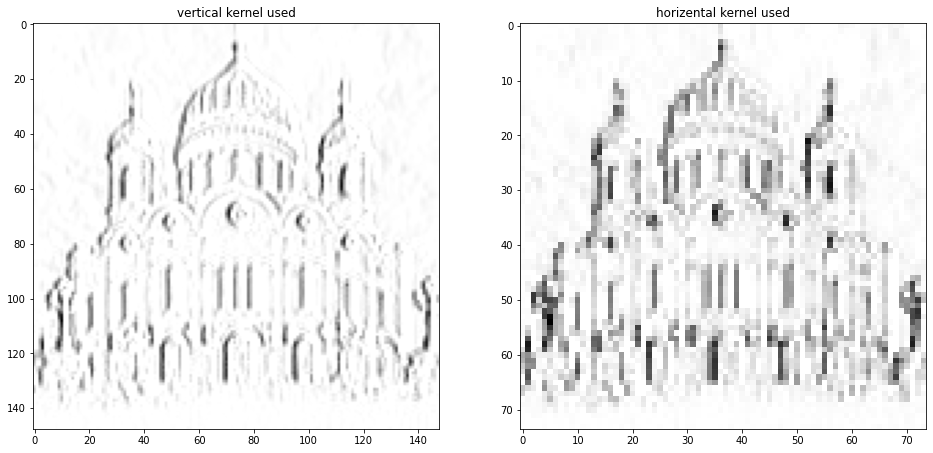

In [126]:
fig, ( ax1, ax2 ) = plt.subplots( 1, 2, figsize=(16,9))

ax1.imshow( activation_map.squeeze().detach().numpy(), cmap='binary' )
ax1.set_title('vertical kernel used')

ax2.imshow( pMap.squeeze().detach().numpy(), cmap='binary' )
ax2.set_title('horizental kernel used')

plt.show()